<a href="https://colab.research.google.com/github/Mc4minta/AIB5-PcapAttackClassifier/blob/main/EvaluateModel_Benign_Normal_Other.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Full Step for evaluation (my model)
- list pcap zip
  - in `/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForBaseline`
- unzip each zip
- iterate through each attack
- iterate to each attack pcap files
- convert to FlowCSV
- process packet map
- preprocess_df
- load model
- predict
- combined label with packet_index
- convert flow-label-index to packetindex-label
- list of predicted label from high to low (final_df)

## final_df format:

| pcap label     | packet label   | ranked_label                    |
| -------------- | -------------- | ------------------------------- |
| FTP-Bruteforce | FTP-Bruteforce | [FTP-Bruteforce,SSH-Bruteforce] |
| Benign         | Benign         | [Benign]                        |

## Evaluate by comparing:
- pcap label and label
- y_test = pcap label
- y_pred = label

## label_rank
- is for tie breaker with baseline just in case

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load model

In [2]:
# define function for model loading

import joblib
def load_model(model_name):
  model_path = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/' + model_name
  model = joblib.load(model_path)
  return model

# model = load_model(model_name)
# print(model)

In [3]:
# load model

model_name = 'RandomForest400IntPortCIC1718-2.pkl'
model = load_model(model_name)
print(model)
attacks = model.classes_
print(attacks)

RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42)
['Benign' 'DoS-HTTP-Flood' 'DoS-Slow-Rate' 'FTP-Bruteforce' 'PortScan'
 'SSH-Bruteforce']


In [4]:
attacks = ['Benign']

In [5]:
print(attacks)

['Benign']


# Setup

In [6]:
# list pcap zip
import os
pcap_zip_dir = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForBaseline/'
files = os.listdir(pcap_zip_dir)
for file in files:
  print(file)

DoS.zip
DDoS.zip
PortScan.zip
Benign.zip
DoS-HTTP-Flood.zip
Benign2.zip
DoS-overall.zip
DoS-Layer3and4.zip
FTP-Bruteforce.zip
SSH-Bruteforce.zip
DoS-Slow-Rate.zip


In [7]:
# list flow zip
import os
pcap_zip_dir = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForbaseline_csv/'
files = os.listdir(pcap_zip_dir)
for file in files:
  print(file)

DoS_csv.zip
DDoS_csv.zip
PortScan_csv.zip
Benign_csv.zip
Benign2_csv.zip
DoS-HTTP-Flood_csv.zip
DoS-Layer3and4_csv.zip
DoS-overall_csv.zip
FTP-Bruteforce_csv.zip
SSH-Bruteforce_csv.zip
DoS-Slow-Rate_csv.zip


In [8]:
'''
# list each attack folder without '.zip' and append to attacks[]
pcap_zip_dir = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForBaseline/'
files = os.listdir(pcap_zip_dir)
attacks = []
for file in files:
  attacks.append(file[:-4])
for attack in attacks:
  print(attack)
'''

"\n# list each attack folder without '.zip' and append to attacks[]\npcap_zip_dir = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForBaseline/'\nfiles = os.listdir(pcap_zip_dir)\nattacks = []\nfor file in files:\n  attacks.append(file[:-4])\nfor attack in attacks:\n  print(attack)\n"

In [8]:
attacks

['Benign']

In [9]:
# define function to unzip(attack.zip)
import zipfile

def unzip_attack_zip(attack):
  pcap_zip_dir = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForBaseline/'
  if(attack[-4:]=='.zip'):
    zip_file_name = attack
  else:
    zip_file_name = attack + '.zip'
  zip_file_path = os.path.join(pcap_zip_dir, zip_file_name)
  destination_directory = '/content/'
  try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(destination_directory)
    print(f"'{zip_file_name}' unzipped to '{destination_directory}'.")
  except Exception as e:
      print(f"Error : {e}")

# unzip_attack_zip('DDoS')

In [10]:
# define function to unzip(attack_csv.zip)
import zipfile

def unzip_attack_flow(attack):
  pcap_zip_dir = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForbaseline_csv/'
  zip_file_name = attack + '_csv.zip'
  zip_file_path = os.path.join(pcap_zip_dir, zip_file_name)
  destination_directory = '/content/'
  try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(destination_directory)
    print(f"'{zip_file_name}' unzipped to '{destination_directory}'.")
  except Exception as e:
      print(f"Error : {e}")

# unzip_attack_flow('DDoS')

In [11]:
# iterate through each attack_csv .zip and unzip it
for attack in attacks:
  print(f"Processing {attack}_csv...")
  if(f'{attack}_csv' not in os.listdir('/content/')):
    unzip_attack_flow(attack)
  else:
    print(f"{attack}_csv already unzipped")

Processing Benign_csv...
'Benign_csv.zip' unzipped to '/content/'.


In [12]:
# iterate through each attack .zip and unzip it
for attack in attacks:
  print(f"Processing {attack}...")
  if(attack not in os.listdir('/content/')):
    unzip_attack_zip(attack)
  else:
    print(f"{attack} already unzipped")

Processing Benign...
'Benign.zip' unzipped to '/content/'.


In [13]:
# clear unused file
for attack in attacks:
  pcap_dir = f'/content/{attack}'
  flow_dir = f'/content/{attack}_csv'
  files = os.listdir(pcap_dir)
  for file in files:
    file_name = file[:-5]
    if 'normal_' in file_name:
      os.remove(f'{pcap_dir}/{file_name}.pcap')
      print(f'Removed {pcap_dir}/{file_name}')
    if 'normal_' in file_name:
      os.remove(f'{pcap_dir}/{file_name}_ISCX.csv')
      print(f'Removed {pcap_dir}/{file_name}')

In [14]:
# list all pcap file in each attack

for attack in attacks:
  print('--------------------------------')
  print(f"PCAP for {attack}")
  print('--------------------------------')
  attack_pcaps = os.listdir(f'/content/{attack}')
  for attack_pcap in attack_pcaps:
    print(attack_pcap)

--------------------------------
PCAP for Benign
--------------------------------
Normal-h3_11.pcap
Normal-h3_1.pcap
Normal-h3_5.pcap
Normal-h3_10.pcap
DoS-GoldenEye_benign.pcap
DoS-Hulk_benign.pcap
Normal-h3_6.pcap
Normal-h3_3.pcap
Normal-h3_9.pcap
Normal-h3_12.pcap
Normal-h3_2.pcap
Normal-h3_8.pcap
Normal-h3_4.pcap


In [15]:
# list all csv file in each attack

for attack in attacks:
  print('--------------------------------')
  print(f"CSV for {attack}")
  print('--------------------------------')
  attack_flows = os.listdir(f'/content/{attack}_csv')
  for attack_flow in attack_flows:
    print(attack_flow)

--------------------------------
CSV for Benign
--------------------------------
Normal-h3_10_ISCX.csv
Normal-h3_11_ISCX.csv
Normal-h3_6_ISCX.csv
Normal-h3_2_ISCX.csv
Normal-h3_5_ISCX.csv
Normal-h3_8_ISCX.csv
Normal-h3_9_ISCX.csv
DoS-Hulk_benign_ISCX.csv
Normal-h3_1_ISCX.csv
Normal-h3_12_ISCX.csv
Normal-h3_3_ISCX.csv
Normal-h3_4_ISCX.csv
DoS-GoldenEye_benign_ISCX.csv


# Map

In [16]:
# create attack_index folder

import os
for attack in attacks:
  os.makedirs(f'/content/{attack}_index', exist_ok=True)
  print(f"Created {attack}_index folder")

Created Benign_index folder


In [17]:
# install scapy

!pip install scapy > /content/log.txt

In [18]:
# define function for simulating cicflowmter


import time
import random
import csv
import sys
from collections import namedtuple
import ipaddress # For robust IP address comparison
import pandas as pd # Import pandas

# Import Scapy for PCAP reading and parsing
# You might need to install it: pip install scapy
try:
    from scapy.all import rdpcap, IP, TCP, UDP
except ImportError:
    print("Scapy not found. Please install it using: pip install scapy")
    sys.exit(1)

# Define a Packet structure to standardize data from Scapy packets
# 'index' corresponds to the sequential position in the PCAP file,
# which is similar to the 'id' in CICFlowMeter's BasicPacketInfo.java
Packet = namedtuple('Packet', ['index', 'timestamp', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'length', 'has_fin_flag'])

class Flow:
    """
    Simulates a network flow, similar to BasicFlow.java.
    A flow is identified by its 5-tuple and stores a list of packet indices
    that belong to this flow. It also tracks basic flow statistics and timestamps.
    """
    def __init__(self, flow_key, first_packet):
        self.flow_key = flow_key
        # This list directly maps the flow to its packet indices (IDs)
        self.packet_indices = [first_packet.index]
        # Store packet timestamps as well for export
        self.packet_timestamps = [int(first_packet.timestamp * 1_000_000)] # Convert to microseconds

        self.start_time = int(first_packet.timestamp * 1_000_000) # Microseconds
        self.last_packet_time = int(first_packet.timestamp * 1_000_000) # Microseconds
        self.packet_count = 1
        self.byte_count = first_packet.length
        self.fwd_packets = [] # Simulating BasicFlow's 'forward' list
        self.bwd_packets = [] # Simulating BasicFlow's 'backward' list

        # Determine the initial direction based on the first packet's original IPs
        # This is used for 'forward' and 'backward' packet grouping within the flow,
        # distinct from the canonical direction used for the flow_key.
        self.initial_src_ip = first_packet.src_ip

        # Add first packet to appropriate directional list
        if self._is_forward_packet(first_packet):
            self.fwd_packets.append(first_packet)
        else:
            self.bwd_packets.append(first_packet)

    def add_packet(self, packet):
        """Adds a packet to the flow and updates flow statistics."""
        self.packet_indices.append(packet.index)
        self.packet_timestamps.append(int(packet.timestamp * 1_000_000)) # Store timestamp in microseconds

        self.packet_count += 1
        self.byte_count += packet.length

        # Update directional packet lists and IATs (simplified for simulation)
        if self._is_forward_packet(packet):
            self.fwd_packets.append(packet)
            # In real CICFlowMeter, IATs and other stats would be updated here, e.g.:
            # if len(self.fwd_packets) > 1:
            #     self.fwd_iat.add_value(packet.timestamp - self.fwd_packets[-2].timestamp)
        else:
            self.bwd_packets.append(packet)
            # if len(self.bwd_packets) > 1:
            #     self.bwd_iat.add_value(packet.timestamp - self.bwd_packets[-2].timestamp)

        # Update last packet time for overall flow duration/IAT calculation
        self.last_packet_time = int(packet.timestamp * 1_000_000) # Microseconds

    def get_flow_duration(self):
        """Calculates the duration of the flow in microseconds."""
        return self.last_packet_time - self.start_time

    def _is_forward_packet(self, packet):
        """
        Determines if a packet is in the forward direction relative to the flow's initial direction.
        This uses the original src_ip of the *first* packet to define "forward" for feature accumulation,
        which is consistent with CICFlowMeter's internal `BasicFlow` logic.
        """
        return packet.src_ip == self.initial_src_ip

    def __repr__(self):
        return (f"Flow(key={self.flow_key}, total_packets={self.packet_count}, "
                f"duration={self.get_flow_duration():.4f}us, "
                f"total_bytes={self.byte_count}B, "
                f"fwd_pkts={len(self.fwd_packets)}, bwd_pkts={len(self.bwd_packets)}, "
                f"packet_indices={self.packet_indices})")

    def to_csv_row(self):
        """
        Converts the flow data into a dictionary suitable for CSV writing.
        This provides a simplified representation of the features CICFlowMeter extracts,
        but crucially includes the 'Packet Indices' and 'Packet Timestamps' columns.
        The 'Flow ID', 'Src IP', 'Dst IP', 'Src Port', 'Dst Port' are taken from the
        canonical flow_key for consistency with CICFlowMeter's output format.
        """
        # The flow_key tuple already holds the normalized 5-tuple as generated by generate_flow_key
        canonical_src_ip, canonical_dst_ip, canonical_src_port, canonical_dst_port, proto = self.flow_key

        return {
            'Flow ID': f"{canonical_src_ip}-{canonical_dst_ip}-{canonical_src_port}-{canonical_dst_port}-{proto}",
            'Src IP': canonical_src_ip,
            'Src Port': canonical_src_port,
            'Dst IP': canonical_dst_ip,
            'Dst Port': canonical_dst_port,
            'Protocol': proto,
            'Flow Duration (us)': self.get_flow_duration(),
            'Total Packets': self.packet_count,
            'Total Bytes': self.byte_count,
            'Fwd Packets': len(self.fwd_packets), # These counts are based on internal 'initial_src_ip'
            'Bwd Packets': len(self.bwd_packets), # These counts are based on internal 'initial_src_ip'
            'Packet Indices': str(self.packet_indices), # Convert list to string for CSV column
            'Packet Timestamps': str(self.packet_timestamps) # Convert list to string for CSV column
            # Add more CICFlowMeter-like features here if needed
            # 'Flow Pkts/s': self.packet_count / (self.get_flow_duration() / 1_000_000.0) if self.get_flow_duration() > 0 else 0,
            # 'Avg Fwd Pkt Len': sum(p.length for p in self.fwd_packets) / len(self.fwd_packets) if self.fwd_packets else 0,
        }


def generate_flow_key(packet):
    """
    Generates a unique key for a flow based on the 5-tuple,
    mimicking CICFlowMeter's Java BasicPacketInfo.generateFlowId() logic
    for canonicalizing IP addresses and ports.

    IMPORTANT: This function uses the raw protocol number, matching BasicPacketInfo.java.
    Any mapping of non-TCP/UDP/ICMP protocols to '0' happens *after* Flow ID generation
    in CICFlowMeter's pipeline (e.g., for display in FlowFeature.featureValue2String),
    and is NOT part of the Flow ID itself.
    """
    # Access attributes by name from the Packet namedtuple
    src_ip_str = packet.src_ip
    dst_ip_str = packet.dst_ip
    src_port = packet.src_port
    dst_port = packet.dst_port
    protocol_int = packet.protocol # Use the raw protocol number here

    # Use ipaddress for robust IP comparison, mirroring Java's byte-by-byte comparison
    try:
        src_ip_obj = ipaddress.ip_address(src_ip_str)
        dst_ip_obj = ipaddress.ip_address(dst_ip_str)
    except ValueError:
        # Fallback for invalid IPs if any, should not happen with valid PCAP data
        return (src_ip_str, dst_ip_str, src_port, dst_port, protocol_int)


    # Determine 'forward' based on IP comparison: canonical_src_ip will be the "smaller" IP
    if src_ip_obj < dst_ip_obj:
        normalized_src_ip = src_ip_str
        normalized_dst_ip = dst_ip_str
        normalized_src_port = src_port
        normalized_dst_port = dst_port
    elif dst_ip_obj < src_ip_obj:
        # Swap IPs and their corresponding ports for normalization
        normalized_src_ip = dst_ip_str
        normalized_dst_ip = src_ip_str
        normalized_src_port = dst_port
        normalized_dst_port = src_port
    else: # IPs are equal (e.g., multicast or broadcast)
        # If IPs are the same, Java's logic does NOT swap ports based on IP.
        # It keeps original src/dst IPs and ports as they are.
        normalized_src_ip = src_ip_str
        normalized_dst_ip = dst_ip_str
        normalized_src_port = src_port
        normalized_dst_port = dst_port

    # The canonical 5-tuple key for the hash map
    return (normalized_src_ip, normalized_dst_ip, normalized_src_port, normalized_dst_port, protocol_int)

def process_packets_into_flows(packets, flow_timeout_us=120000000, idle_timeout_us=5000000):
    """
    Processes a list of packets and groups them into flows, simulating FlowGenerator.java.
    Args:
        packets (list): A list of Packet namedtuples, derived from PCAP.
        flow_timeout_us (int): Max flow duration in microseconds (120 seconds).
        idle_timeout_us (int): Max idle time within a flow in microseconds (5 seconds).
    Returns:
        dict: A dictionary where keys are unique flow identifiers (combining 5-tuple and a counter)
              and values are Flow objects.
    """
    active_flows = {} # {flow_key_5_tuple: Flow_object}
    completed_flows = {} # {unique_completed_flow_id: Flow_object}

    # Packets are assumed to be already sorted by timestamp when passed from PCAP reader

    completed_flow_counter = 0

    for packet in packets:
        flow_key = generate_flow_key(packet)
        current_timestamp_us = int(packet.timestamp * 1_000_000) # Convert seconds to microseconds

        # Check if this packet belongs to an existing active flow
        if flow_key in active_flows:
            flow = active_flows[flow_key]

            # Check for IDLE timeout first (packet arrival AFTER idle period)
            if (current_timestamp_us - flow.last_packet_time) > idle_timeout_us:
                # Flow idle timed out, finish current flow and start new one
                completed_flows[f"{flow_key}_{completed_flow_counter}"] = flow
                completed_flow_counter += 1
                active_flows.pop(flow_key) # Remove old flow from active

                new_flow = Flow(flow_key, packet)
                active_flows[flow_key] = new_flow

            # Check for TOTAL flow timeout (flow duration)
            elif (current_timestamp_us - flow.start_time) > flow_timeout_us:
                # Flow timed out based on total duration, finish current flow and start new one
                completed_flows[f"{flow_key}_{completed_flow_counter}"] = flow
                completed_flow_counter += 1
                active_flows.pop(flow_key) # Remove old flow from active

                new_flow = Flow(flow_key, packet)
                active_flows[flow_key] = new_flow

            # Simulate TCP FIN flag termination
            # Only apply if the protocol is TCP (6) and FIN flag is set.
            # Add the FIN packet to the flow before deciding if it's finished.
            elif packet.protocol == 6 and packet.has_fin_flag:
                flow.add_packet(packet) # Add the FIN packet
                completed_flows[f"{flow_key}_{completed_flow_counter}"] = flow
                completed_flow_counter += 1
                active_flows.pop(flow_key) # Remove from active flows as it's finished

            # Otherwise, add packet to existing active flow
            else:
                flow.add_packet(packet)
                # No explicit idle time update needed in Flow object here,
                # as it's checked upon next packet arrival.

        else:
            # New flow, or a flow that previously completed and was removed from active_flows
            new_flow = Flow(flow_key, packet)
            active_flows[flow_key] = new_flow

    # After processing all packets, move any remaining active flows to completed flows
    for flow_key, flow in list(active_flows.items()): # Iterate over a copy to allow modification
        completed_flows[f"{flow_key}_{completed_flow_counter}"] = flow
        completed_flow_counter += 1
        # No need to pop from active_flows here, as loop is over.

    return completed_flows

def extract_packet_info_from_pcap(pcap_file_path):
    """
    Reads a PCAP file using Scapy and extracts relevant information into Packet namedtuples.
    Assigns a sequential index to each packet as it's read.
    Broadened to include all IP packets, not just TCP/UDP.
    """
    print(f"Reading packets from {pcap_file_path}...")
    extracted_packets = []

    try:
        packets_scapy = rdpcap(pcap_file_path)
        total_packets = len(packets_scapy)
        print(f"Successfully read {total_packets} packets from {pcap_file_path}.")
    except FileNotFoundError:
        print(f"Error: PCAP file not found at {pcap_file_path}.")
        return [], 0 # Return empty list and 0 total packets on error
    except Exception as e:
        print(f"An error occurred while reading PCAP file {pcap_file_path}: {e}")
        return [], 0 # Return empty list and 0 total packets on other errors


    for i, pkt in enumerate(packets_scapy):
        src_ip = None
        dst_ip = None
        src_port = 0 # Default to 0 for non-TCP/UDP protocols or if ports are missing
        dst_port = 0 # Default to 0 for non-TCP/UDP protocols or if ports are missing
        protocol = None
        has_fin = False

        # Ensure IP layer exists
        if IP in pkt:
            src_ip = pkt[IP].src
            dst_ip = pkt[IP].dst
            protocol = pkt[IP].proto # e.g., 6 for TCP, 17 for UDP, 1 for ICMP, 2 for IGMP, etc.

            # Check for transport layer (TCP or UDP) to get ports and flags
            if TCP in pkt:
                src_port = pkt[TCP].sport
                dst_port = pkt[TCP].dport
                has_fin = bool(pkt[TCP].flags & 0x01) # FIN is bit 0 in TCP flags
            elif UDP in pkt:
                src_port = pkt[UDP].sport
                dst_port = pkt[UDP].dport
            # For other IP protocols (like ICMP, IGMP, etc.), src_port and dst_port remain 0.

            # Only process packets with valid IP information
            # This condition is now implicitly true for any packet with an IP layer,
            # as src_ip, dst_ip, and protocol will be extracted.
            extracted_packets.append(Packet(
                index=i,
                timestamp=pkt.time, # Scapy's pkt.time is already in seconds (float)
                src_ip=src_ip,
                dst_ip=dst_ip,
                src_port=src_port,
                dst_port=dst_port,
                protocol=protocol,
                length=len(pkt), # Total packet length
                has_fin_flag=has_fin
            ))

    # Scapy's rdpcap usually returns packets in capture order (by timestamp),
    # but explicit sorting ensures strict chronological processing as in CICFlowMeter.
    extracted_packets.sort(key=lambda p: p.timestamp)
    print(f"Extracted {len(extracted_packets)} valid packets from PCAP.")
    return extracted_packets,total_packets

def extract_flows_from_pcap(pcap_file_path: str) -> pd.DataFrame:
    """
    Orchestrates the entire process of extracting network flows from a PCAP file,
    mimicking CICFlowMeter's logic, and returns the flows as a Pandas DataFrame.

    Args:
        pcap_file_path (str): The path to the input PCAP file.

    Returns:
        pd.DataFrame: A DataFrame where each row represents a discovered flow,
                      including 'Packet Indices' and 'Packet Timestamps'.
                      Returns an empty DataFrame if no valid packets are found or
                      if PCAP file cannot be read.
    """
    # Step 1: Extract packet information from the PCAP file
    packets_from_pcap,total_packets = extract_packet_info_from_pcap(pcap_file_path)

    if not packets_from_pcap:
        print("No valid packets found or PCAP file could not be read. Returning empty DataFrame.")
        return pd.DataFrame(), total_packets # Return empty DataFrame and total_packets (which will be 0 on error)

    print("\nProcessing packets into flows (simulating CICFlowMeter logic)...")
    # Step 2: Process the extracted packets into flows
    # Default timeouts are 120 seconds (flow) and 5 seconds (idle) for CICFlowMeter
    flows_data = process_packets_into_flows(packets_from_pcap,
                                            flow_timeout_us=120_000_000,
                                            idle_timeout_us=5_000_000)

    print(f"\nDiscovered {len(flows_data)} flows.")

    # Step 3: Convert discovered flows to a list of dictionaries for DataFrame creation
    flows_list_of_dicts = []
    for flow_unique_id, flow_obj in flows_data.items():
        flows_list_of_dicts.append(flow_obj.to_csv_row())

    # Create DataFrame from the list of flow dictionaries
    flows_df = pd.DataFrame(flows_list_of_dicts)

    # Step 4: Display a summary of generated flows (for console output)
    if not flows_df.empty:
        print("\nHead of the generated Flows DataFrame:")
        print(flows_df.head())
        print("\nColumns in the generated Flows DataFrame:")
        print(flows_df.columns.tolist())
    else:
        print("\nNo flows generated to display.")

    return flows_df,total_packets

In [19]:
# simulate cicflowmeter for each pcap file

for attack in attacks:
  pcap_files = os.listdir(f'/content/{attack}')
  for pcap_file in pcap_files:
    file_name = pcap_file.split('.')[0]
    pcap_file_name = f'{file_name}.pcap'
    pcap_file_dir = f'/content/{attack}/'

    csv_file_name = f'{file_name}.csv'
    csv_file_dir = f'/content/{attack}_csv/'

    index_file_name = f'{file_name}_index.csv'
    index_file_dir = f'/content/{attack}_index/'

    simulated_flows_df,total_packets = extract_flows_from_pcap(pcap_file_dir+pcap_file_name)

    # Check if the dataframe is not empty before adding the column and saving
    if not simulated_flows_df.empty:
      simulated_flows_df['Total_Packets'] = total_packets
      simulated_flows_df.to_csv(index_file_dir+index_file_name, index=False)
    else:
      print(f"No flows extracted from {pcap_file_name}. Skipping CSV creation.")

Reading packets from /content/Benign/Normal-h3_11.pcap...
Successfully read 214650 packets from /content/Benign/Normal-h3_11.pcap.
Extracted 212329 valid packets from PCAP.

Processing packets into flows (simulating CICFlowMeter logic)...

Discovered 9732 flows.

Head of the generated Flows DataFrame:
                                     Flow ID          Src IP  Src Port  \
0  74.125.193.138-192.168.20.133-443-35640-6  74.125.193.138       443   
1  74.125.193.138-192.168.20.133-443-35640-6  74.125.193.138       443   
2  192.168.20.133-209.85.202.132-41106-443-6  192.168.20.133     41106   
3  192.168.20.133-209.85.202.132-41110-443-6  192.168.20.133     41110   
4  192.168.20.133-209.85.202.132-41112-443-6  192.168.20.133     41112   

           Dst IP  Dst Port  Protocol  Flow Duration (us)  Total Packets  \
0  192.168.20.133     35640         6               42458             18   
1  192.168.20.133     35640         6                2187              3   
2  209.85.202.132       

In [20]:
# list all index.csv files

for attack in attacks:
  print('--------------------------------')
  print(f"CSV in {attack}_index")
  print('--------------------------------')
  attack_indexs = os.listdir(f'/content/{attack}_index')
  for attack_index in attack_indexs:
    print(attack_index)

--------------------------------
CSV in Benign_index
--------------------------------
Normal-h3_10_index.csv
Normal-h3_8_index.csv
Normal-h3_1_index.csv
DoS-Hulk_benign_index.csv
Normal-h3_5_index.csv
Normal-h3_4_index.csv
Normal-h3_12_index.csv
Normal-h3_9_index.csv
DoS-GoldenEye_benign_index.csv
Normal-h3_11_index.csv
Normal-h3_2_index.csv
Normal-h3_6_index.csv
Normal-h3_3_index.csv


In [21]:
# define function for combining simulated and original flow

import pandas as pd
import ipaddress # For robust IP address comparison

# --- Start: Helper Functions (from previous scripts, for self-contained use) ---

def generate_flow_key(packet_components):
    """
    Generates a unique key for a flow based on the 5-tuple,
    mimicking CICFlowMeter's Java BasicPacketInfo.generateFlowId() logic
    for canonicalizing IP addresses and ports.

    This function uses the raw protocol number, matching BasicPacketInfo.java.
    Any mapping of non-TCP/UDP/ICMP protocols to '0' happens *after* Flow ID generation
    in CICFlowMeter's pipeline (e.g., for display in FlowFeature.featureValue2String),
    and is NOT part of the Flow ID itself.

    Args:
        packet_components (tuple): A tuple containing (src_ip_str, dst_ip_str, src_port, dst_port, protocol_int)
    Returns:
        tuple: Canonical 5-tuple (normalized_src_ip, normalized_dst_ip, normalized_src_port, normalized_dst_port, normalized_protocol_int)
    """
    src_ip_str, dst_ip_str, src_port, dst_port, protocol_int = packet_components

    # Use ipaddress for robust IP comparison, mirroring Java's byte-by-byte comparison
    try:
        src_ip_obj = ipaddress.ip_address(src_ip_str)
        dst_ip_obj = ipaddress.ip_address(dst_ip_str)
    except ValueError:
        # Fallback for invalid IPs if any, should not happen with valid PCAP data
        return (src_ip_str, dst_ip_str, src_port, dst_port, protocol_int)


    # Determine 'forward' based on IP comparison: canonical_src_ip will be the "smaller" IP
    if src_ip_obj < dst_ip_obj:
        normalized_src_ip = src_ip_str
        normalized_dst_ip = dst_ip_str
        normalized_src_port = src_port
        normalized_dst_port = dst_port
    elif dst_ip_obj < src_ip_obj:
        # Swap IPs and their corresponding ports for normalization
        normalized_src_ip = dst_ip_str
        normalized_dst_ip = src_ip_str
        normalized_src_port = dst_port
        normalized_dst_port = src_port
    else: # IPs are equal (e.g., multicast or broadcast)
        # If IPs are the same, Java's logic does NOT swap ports based on IP.
        # It keeps original src/dst IPs and ports as they are.
        normalized_src_ip = src_ip_str
        normalized_dst_ip = dst_ip_str
        normalized_src_port = src_port
        normalized_dst_port = dst_port

    # The canonical 5-tuple key for the hash map
    return (normalized_src_ip, normalized_dst_ip, normalized_src_port, normalized_dst_port, protocol_int)

def parse_flow_id_string(flow_id_str):
    """
    Parses a Flow ID string (e.g., 'IP1-IP2-Port1-Port2-Protocol') into its components.
    Returns a tuple (src_ip, dst_ip, src_port, dst_port, protocol_int) or None if parsing fails.
    """
    parts = flow_id_str.split('-')
    if len(parts) == 5:
        try:
            return (parts[0], parts[1], int(parts[2]), int(parts[3]), int(parts[4]))
        except ValueError:
            return None
    return None

def read_flows_to_dataframe(filepath: str, is_simulated_output: bool = False) -> pd.DataFrame:
    """
    Reads flow data from a CSV file into a Pandas DataFrame.
    Adds a 'Canonical_Flow_ID' column for merging.
    Parses 'Packet Indices' and 'Packet Timestamps' for simulated output.
    This function keeps all original rows and does not deduplicate based on Canonical Flow ID.

    Args:
        filepath (str): Path to the CSV file.
        is_simulated_output (bool): True if reading our simulated output (with 'Packet Indices' column),
                                    False if reading original CICFlowMeter output.

    Returns:
        pd.DataFrame: The loaded DataFrame with an added 'Canonical_Flow_ID' column.
                      Returns an empty DataFrame if the file is not found or an error occurs.
    """
    try:
        df = pd.read_csv(filepath)

        # Create a new column with parsed components for canonicalization
        df['Parsed_Flow_Components'] = df['Flow ID'].apply(parse_flow_id_string)

        # Filter out rows where parsing failed
        df = df.dropna(subset=['Parsed_Flow_Components'])

        # Apply canonicalization to create 'Canonical_Flow_ID'
        df['Canonical_Flow_ID'] = df['Parsed_Flow_Components'].apply(generate_flow_key).apply(lambda x: "-".join(map(str, x)))

        # Clean up temporary column
        df = df.drop(columns=['Parsed_Flow_Components'])

        total_packets = 0
        # Special handling for our simulated output's 'Packet Indices' and 'Packet Timestamps'
        if is_simulated_output:
            if 'Total_Packets' in df.columns:
                total_packets = df['Total_Packets'].iloc[0]
            if 'Packet Indices' in df.columns:
                try:
                    df['Packet Indices'] = df['Packet Indices'].apply(eval)
                except Exception as e:
                    print(f"Warning: Could not parse 'Packet Indices' in {filepath}: {e}")
                    df['Packet Indices'] = [[]] * len(df) # Assign empty list on error
            if 'Packet Timestamps' in df.columns:
                try:
                    df['Packet Timestamps'] = df['Packet Timestamps'].apply(eval)
                except Exception as e:
                    print(f"Warning: Could not parse 'Packet Timestamps' in {filepath}: {e}")
                    df['Packet Timestamps'] = [[]] * len(df) # Assign empty list on error

        print(f"Successfully loaded {len(df)} flows from '{filepath}'.")
        return df,total_packets
    except FileNotFoundError:
        print(f"Error: File not found at '{filepath}'")
        return pd.DataFrame() # Return empty DataFrame on error
    except Exception as e:
        print(f"Error reading or processing CSV file '{filepath}': {e}")
        return pd.DataFrame() # Return empty DataFrame on error

# --- End: Helper Functions ---

def merge_flows_and_return_dataframe(simulated_df: pd.DataFrame, original_df: pd.DataFrame) -> pd.DataFrame:
    """
    Merges a DataFrame of simulated flows with a DataFrame of original CICFlowMeter flows
    based on a canonical flow ID. It adds the 'Simulated Packet Indices' column to the
    original flow data where a match is found.

    Args:
        simulated_df (pd.DataFrame): DataFrame containing flows generated by the simulation.
                                     Expected to have 'Canonical_Flow_ID' and 'Packet Indices'.
        original_df (pd.DataFrame): DataFrame containing flows from the original CICFlowMeter.
                                    Expected to have 'Canonical_Flow_ID' and original flow features.

    Returns:
        pd.DataFrame: A merged DataFrame containing original CICFlowMeter features
                      and 'Simulated Packet Indices' for matching flows.
                      Returns an empty DataFrame if inputs are invalid.
    """
    if simulated_df.empty or original_df.empty:
        print("Cannot merge flows due to empty input DataFrames.")
        return pd.DataFrame()

    # Perform a left merge on the 'Canonical_Flow_ID'
    # Keep all rows from original_df, and add matching data from simulated_df.
    # Select only 'Canonical_Flow_ID' and 'Packet Indices' from the simulated_df.
    merged_df = pd.merge(
        original_df,
        simulated_df[['Canonical_Flow_ID', 'Packet Indices']],
        on='Canonical_Flow_ID',
        how='left',
        suffixes=('_original', '_simulated')
    )

    # Rename the new column for clarity
    merged_df = merged_df.rename(columns={
        'Packet Indices': 'Simulated Packet Indices'
    })

    # Drop the 'Canonical_Flow_ID' column, as it's only for merging
    merged_df = merged_df.drop(columns=['Canonical_Flow_ID'])

    print("\n--- Merged Flow Data (Original CICFlowMeter with Simulated Packet Indices) ---")
    print(f"Total rows in merged DataFrame: {len(merged_df)}")
    print("Head of the merged DataFrame:")
    print(merged_df.head())

    print("\nColumns in the merged DataFrame:")
    print(merged_df.columns.tolist())

    return merged_df

In [22]:
# combine simulate and original flow , for each flow

for attack in attacks:
  pcap_files = os.listdir(f'/content/{attack}')
  for pcap_file in pcap_files:
    file_name = pcap_file.split('.')[0]
    pcap_file_name = f'{file_name}.pcap'
    pcap_file_dir = f'/content/{attack}/'

    csv_file_name = f'{file_name}_ISCX.csv'
    csv_file_dir = f'/content/{attack}_csv/'

    index_file_name = f'{file_name}_index.csv'
    index_file_dir = f'/content/{attack}_index/'

    simulated_csv_path = f'{index_file_dir}/{index_file_name}'
    original_cic_csv_path = f'{csv_file_dir}/{csv_file_name}'

    # Read the data from both CSVs into DataFrames using the helper function
    simulated_df,total_packets = read_flows_to_dataframe(simulated_csv_path, is_simulated_output=True)
    original_df,placeholder = read_flows_to_dataframe(original_cic_csv_path, is_simulated_output=False)

    # Merge the flows and get the resulting DataFrame
    final_merged_df = merge_flows_and_return_dataframe(simulated_df, original_df)
    final_merged_df['Total_Packets'] = total_packets
    final_merged_df.to_csv(f'{index_file_dir}/{index_file_name}', index=False)

Successfully loaded 9732 flows from '/content/Benign_index//Normal-h3_11_index.csv'.
Successfully loaded 4985 flows from '/content/Benign_csv//Normal-h3_11_ISCX.csv'.

--- Merged Flow Data (Original CICFlowMeter with Simulated Packet Indices) ---
Total rows in merged DataFrame: 47200
Head of the merged DataFrame:
                                     Flow ID          Src IP  Src Port  \
0  192.168.20.133-74.125.193.138-35640-443-6  192.168.20.133     35640   
1  192.168.20.133-74.125.193.138-35640-443-6  192.168.20.133     35640   
2  192.168.20.133-74.125.193.138-35640-443-6  192.168.20.133     35640   
3  192.168.20.133-74.125.193.138-35640-443-6  74.125.193.138       443   
4  192.168.20.133-74.125.193.138-35640-443-6  74.125.193.138       443   

           Dst IP  Dst Port  Protocol            Timestamp  Flow Duration  \
0  74.125.193.138       443         6  07/02/2020 01:50:26          42458   
1  74.125.193.138       443         6  07/02/2020 01:50:26          42458   
2  74.125

# Prediction

In [23]:
# define function for dataframe preprocessing

import pandas as pd
import numpy as np
import ast

def map_port(port):
    if port == 21:
        return 1  # FTP
    elif port == 22:
        return 2  # SSH
    elif port == 53:
        return 3  # DNS
    elif port == 80:
        return 4  # HTTP
    elif port == 443:
        return 5  # HTTPS
    else:
        return 6  # Other

def preprocess_dataframe(df):
    original_indices = set(df.index)

    # replace space in columns name with underscore
    df.columns = df.columns.str.strip().str.replace(' ', '_')

    # drop objects type columns
    columns_to_drop = [
        'Flow_ID','Src_IP','Dst_IP','Src_Port','Protocol','Timestamp','Label'
    ]

    df = df.drop(columns=columns_to_drop)

    # remove rows with missing and infinite values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.dropna()

    # map destination port to 1-6 numbers
    df['Dst_Port'] = df['Dst_Port'].apply(map_port)

    return df

# preprocess_dataframe(df)

In [24]:
# get prediction for each packet

from collections import Counter

def choose_label(labels):
    if all(label == 'Benign' for label in labels):
        return 'Benign'

    # Count non-Benign labels
    non_benign_labels = [label for label in labels if label != 'Benign']
    label_counts = Counter(non_benign_labels)

    # Return the most common non-Benign label
    most_common_label, _ = label_counts.most_common(1)[0]
    return most_common_label

for attack in attacks:
  pcap_files = os.listdir(f'/content/{attack}')
  for pcap_file in pcap_files:
    file_name = pcap_file.split('.')[0]
    pcap_file_name = f'{file_name}.pcap'
    pcap_file_dir = f'/content/{attack}/'

    csv_file_name = f'{file_name}_ISCX.csv'
    csv_file_dir = f'/content/{attack}_csv/'

    index_file_name = f'{file_name}_index.csv'
    index_file_dir = f'/content/{attack}_index/'

    prediction_file_name = f'{file_name}_prediction.csv'
    prediction_file_dir = f'/content/{attack}_prediction/'

    df = pd.read_csv(f'{index_file_dir}/{index_file_name}')
    df = preprocess_dataframe(df)

    total_packets = df['Total_Packets'].iloc[0]
    df = df.drop(columns=['Total_Packets'])
    # print(f"{pcap_file_name} : {total_packets}")

    df_packet_index = df['Simulated_Packet_Indices']
    df_packet_index = df_packet_index.apply(ast.literal_eval)

    df = df.drop(columns=['Simulated_Packet_Indices'])
    df_prediction = model.predict(df)

    df_prediction = pd.DataFrame({
    'Packet_Indices': df_packet_index,
    'Label': df_prediction
    })

    df_prediction = df_prediction.explode('Packet_Indices').reset_index(drop=True)

    # after edit
    df_prediction = df_prediction.groupby('Packet_Indices')['Label'].apply(list).reset_index()
    df_prediction['Chosen_Label'] = df_prediction['Label'].apply(choose_label)

    full_indices = set(range(1, total_packets + 1))
    existing_indices = set(df_prediction['Packet_Indices'])
    missing_indices = sorted(full_indices - existing_indices)

    df_missing = pd.DataFrame({
    'Packet_Indices': missing_indices,
    'Label': [['Benign']] * len(missing_indices),
    'Chosen_Label': ['Benign'] * len(missing_indices),
    })

    df_prediction = pd.concat([df_prediction, df_missing], ignore_index=True)

    df_prediction.sort_values(by='Packet_Indices', inplace=True)
    df_prediction.reset_index(drop=True, inplace=True)

    os.makedirs(prediction_file_dir, exist_ok=True)
    df_prediction.to_csv(f'{prediction_file_dir}/{prediction_file_name}', index=False)

In [25]:
# just seeing choosen_label value counts

for attack in attacks:
  pcap_files = os.listdir(f'/content/{attack}')
  for pcap_file in pcap_files:
    file_name = pcap_file.split('.')[0]
    pcap_file_name = f'{file_name}.pcap'
    pcap_file_dir = f'/content/{attack}/'

    csv_file_name = f'{file_name}_ISCX.csv'
    csv_file_dir = f'/content/{attack}_csv/'

    index_file_name = f'{file_name}_index.csv'
    index_file_dir = f'/content/{attack}_index/'

    prediction_file_name = f'{file_name}_prediction.csv'
    prediction_file_dir = f'/content/{attack}_prediction/'

    df = pd.read_csv(f'{prediction_file_dir}/{prediction_file_name}')
    print(f"{pcap_file_name} = {df['Chosen_Label'].value_counts()}")

Normal-h3_11.pcap = Chosen_Label
Benign    214651
Name: count, dtype: int64
Normal-h3_1.pcap = Chosen_Label
Benign    39868
Name: count, dtype: int64
Normal-h3_5.pcap = Chosen_Label
Benign           343882
DoS-Slow-Rate        24
Name: count, dtype: int64
Normal-h3_10.pcap = Chosen_Label
Benign    104984
Name: count, dtype: int64
DoS-GoldenEye_benign.pcap = Chosen_Label
Benign    1604
Name: count, dtype: int64
DoS-Hulk_benign.pcap = Chosen_Label
Benign    1604
Name: count, dtype: int64
Normal-h3_6.pcap = Chosen_Label
Benign    303018
Name: count, dtype: int64
Normal-h3_3.pcap = Chosen_Label
Benign    33652
Name: count, dtype: int64
Normal-h3_9.pcap = Chosen_Label
Benign    127459
Name: count, dtype: int64
Normal-h3_12.pcap = Chosen_Label
Benign    325015
Name: count, dtype: int64
Normal-h3_2.pcap = Chosen_Label
Benign    101932
Name: count, dtype: int64
Normal-h3_8.pcap = Chosen_Label
Benign    101525
Name: count, dtype: int64
Normal-h3_4.pcap = Chosen_Label
Benign            204455
SS

In [26]:
os.makedirs('/content/Result', exist_ok=True)

In [27]:
# get the pcap label with most label packets and save to result

import os
import pandas as pd

def get_dominant_label(label_series):
    counts = label_series.value_counts()
    if len(counts) == 1 and 'Benign' in counts:
        return 'Benign'
    counts = counts.drop('Benign', errors='ignore')
    return counts.idxmax() if not counts.empty else 'Benign'



for attack in attacks:
    results = []
    pcap_files = os.listdir(f'/content/{attack}')
    for pcap_file in pcap_files:
        file_name = pcap_file.split('.')[0]
        pcap_file_name = f'{file_name}.pcap'

        prediction_file_name = f'{file_name}_prediction.csv'
        prediction_file_dir = f'/content/{attack}_prediction'
        prediction_csv_path = os.path.join(prediction_file_dir, prediction_file_name)

        if not os.path.isfile(prediction_csv_path):
            continue  # Skip missing prediction files

        df = pd.read_csv(prediction_csv_path)
        final_pcap_label = get_dominant_label(df['Chosen_Label'])

        results.append({
            'File_Name': pcap_file_name,
            'Result': final_pcap_label,
            'Attack': attack
        })

    df_all_results = pd.DataFrame(results)
    df_all_results.to_csv(f'/content/Result/{attack}_result.csv', index=False)

In [28]:
# prompt: generated sklearn classification result of each attack_result with y_test being Attack column and y_pred being Result column

from sklearn.metrics import classification_report

for attack in attacks:
  result_csv_path = f'/content/Result/{attack}_result.csv'
  if os.path.exists(result_csv_path):
    df_result = pd.read_csv(result_csv_path)

    y_true = df_result['Attack']
    y_pred = df_result['Result']

    print(f"Classification Report for {attack}:")
    print(classification_report(y_true, y_pred, zero_division=0)) # Use zero_division=0 to handle cases where a class has no predicted samples

  else:
    print(f"No result file found for {attack}.")
  print("-" * 40)

Classification Report for Benign:
                precision    recall  f1-score   support

        Benign       1.00      0.85      0.92        13
 DoS-Slow-Rate       0.00      0.00      0.00         0
SSH-Bruteforce       0.00      0.00      0.00         0

      accuracy                           0.85        13
     macro avg       0.33      0.28      0.31        13
  weighted avg       1.00      0.85      0.92        13

----------------------------------------


In [29]:
from sklearn.metrics import classification_report

all_true_labels = []
all_predicted_labels = []

for attack in attacks:
    pcap_files = os.listdir(f'/content/{attack}')
    for pcap_file in pcap_files:
        file_name = pcap_file.split('.')[0]
        prediction_file_name = f'{file_name}_prediction.csv'
        prediction_file_dir = f'/content/{attack}_prediction/'
        prediction_csv_path = f'{prediction_file_dir}/{prediction_file_name}'

        try:
            df_prediction = pd.read_csv(prediction_csv_path)
            # The true label for all packets in this file is the 'attack' name
            if attack != 'DoS-SlowRate':
                true_label = attack
            else:
                true_label = 'DoS-Slow-Rate'

            # Collect the predicted label for each packet from 'Chosen_Label'
            predicted_labels = df_prediction['Chosen_Label'].tolist()

            # Extend our master lists
            all_true_labels.extend([true_label] * len(predicted_labels))
            all_predicted_labels.extend(predicted_labels)

        except FileNotFoundError:
            print(f"Prediction file not found for {pcap_file}: {prediction_csv_path}")
        except Exception as e:
            print(f"Error processing prediction file {prediction_csv_path}: {e}")

# Now, print the classification report using the collected true and predicted labels
if all_true_labels and all_predicted_labels:
    print("\n--- Classification Report ---")
    # Ensure both lists are of the same length
    if len(all_true_labels) == len(all_predicted_labels):
        print(classification_report(all_true_labels, all_predicted_labels, zero_division=0))
    else:
        print("Error: Mismatch in the number of true labels and predicted labels.")
else:
    print("\nNo data collected to generate a classification report.")


--- Classification Report ---
                precision    recall  f1-score   support

        Benign       1.00      1.00      1.00   1903699
 DoS-Slow-Rate       0.00      0.00      0.00         0
SSH-Bruteforce       0.00      0.00      0.00         0

      accuracy                           1.00   1903699
     macro avg       0.33      0.33      0.33   1903699
  weighted avg       1.00      1.00      1.00   1903699




--- Confusion Matrix ---
[[1903649      24      26]
 [      0       0       0]
 [      0       0       0]]


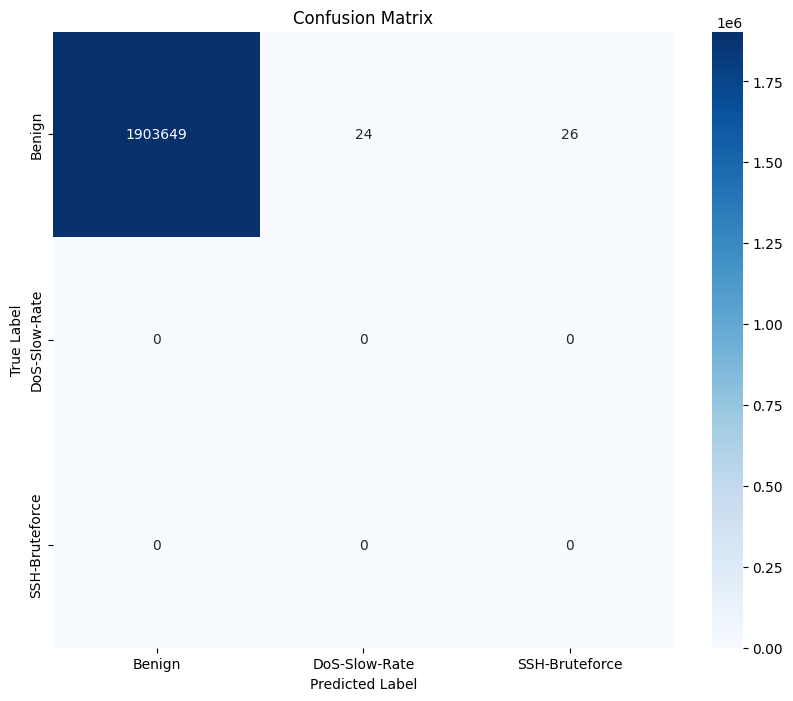

In [30]:
# prompt: do confusion matrix of the from sklearn.metrics import classification_report
# all_true_labels = []
# all_predicted_labels = []
# for attack in attacks:
#     pcap_files = os.listdir(f'/content/{attack}')
#     for pcap_file in pcap_files:
#         file_name = pcap_file.split('.')[0]
#         prediction_file_name = f'{file_name}_prediction.csv'
#         prediction_file_dir = f'/content/{attack}_prediction/'
#         prediction_csv_path = f'{prediction_file_dir}/{prediction_file_name}'
#         try:
#             df_prediction = pd.read_csv(prediction_csv_path)
#             # The true label for all packets in this file is the 'attack' name
#             if attack != 'DoS-SlowRate':
#                 true_label = attack
#             else:
#                 true_label = 'DoS-Slow-Rate'
#             # Collect the predicted label for each packet from 'Chosen_Label'
#             predicted_labels = df_prediction['Chosen_Label'].tolist()
#             # Extend our master lists
#             all_true_labels.extend([true_label] * len(predicted_labels))
#             all_predicted_labels.extend(predicted_labels)
#         except FileNotFoundError:
#             print(f"Prediction file not found for {pcap_file}: {prediction_csv_path}")
#         except Exception as e:
#             print(f"Error processing prediction file {prediction_csv_path}: {e}")
# # Now, print the classification report using the collected true and predicted labels
# if all_true_labels and all_predicted_labels:
#     print("\n--- Classification Report ---")
#     # Ensure both lists are of the same length
#     if len(all_true_labels) == len(all_predicted_labels):
#         print(classification_report(all_true_labels, all_predicted_labels, zero_division=0))
#     else:
#         print("Error: Mismatch in the number of true labels and predicted labels.")
# else:
#     print("\nNo data collected to generate a classification report.") too

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
# Ensure the unique labels are consistent across true and predicted lists
unique_labels = sorted(list(set(all_true_labels + all_predicted_labels)))

if all_true_labels and all_predicted_labels and len(all_true_labels) == len(all_predicted_labels):
    cm = confusion_matrix(all_true_labels, all_predicted_labels, labels=unique_labels)

    print("\n--- Confusion Matrix ---")
    print(cm)

    # Optional: Visualize the confusion matrix using seaborn and matplotlib
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("\nCannot generate Confusion Matrix: Mismatch in the number of true labels and predicted labels or no data collected.")


# Additional


--- Confusion Matrix for Normal-h3_11.pcap ---
[[214651]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


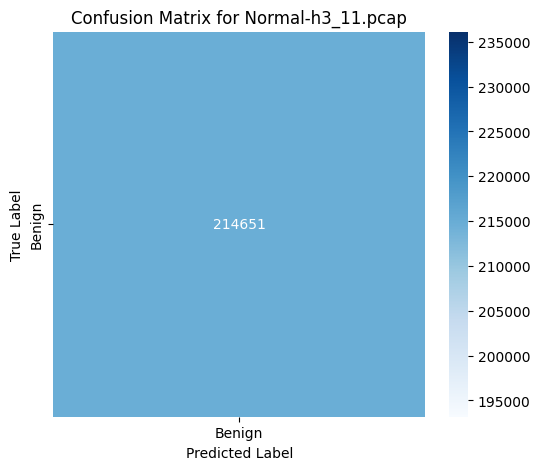


--- Confusion Matrix for Normal-h3_1.pcap ---
[[39868]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


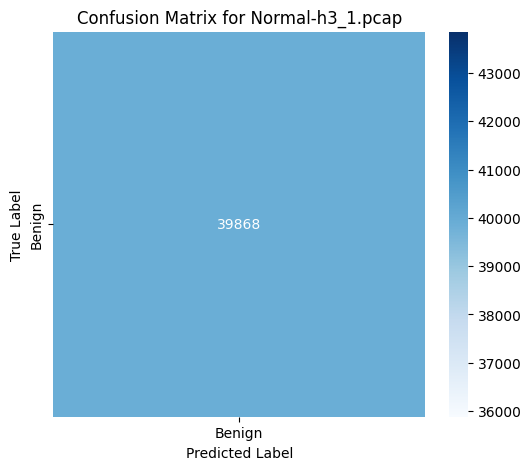


--- Confusion Matrix for Normal-h3_5.pcap ---
[[343882     24]
 [     0      0]]


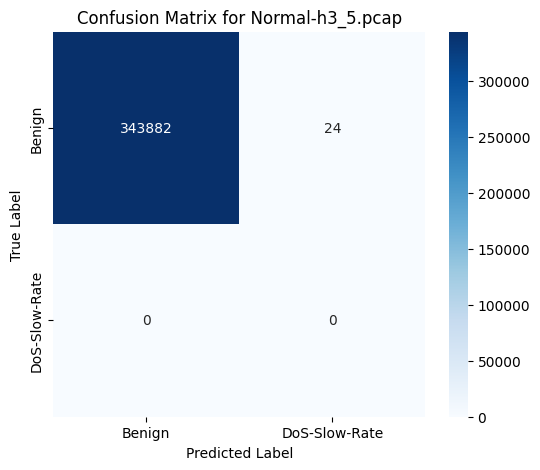


--- Confusion Matrix for Normal-h3_10.pcap ---
[[104984]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


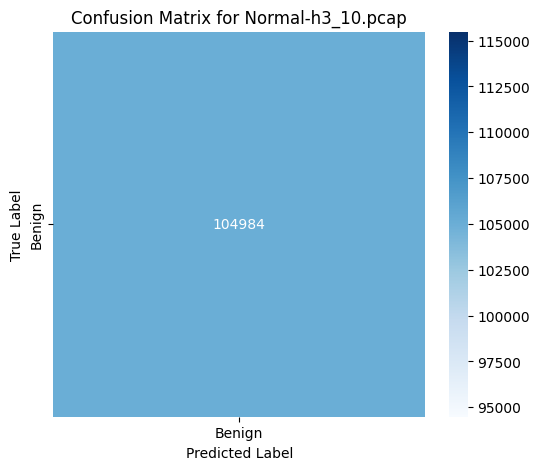

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(



--- Confusion Matrix for DoS-GoldenEye_benign.pcap ---
[[1604]]


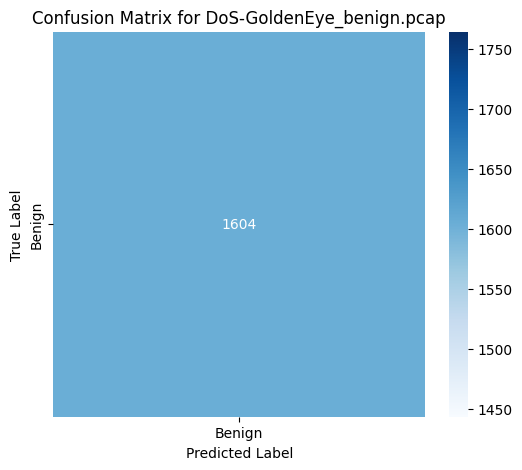


--- Confusion Matrix for DoS-Hulk_benign.pcap ---
[[1604]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


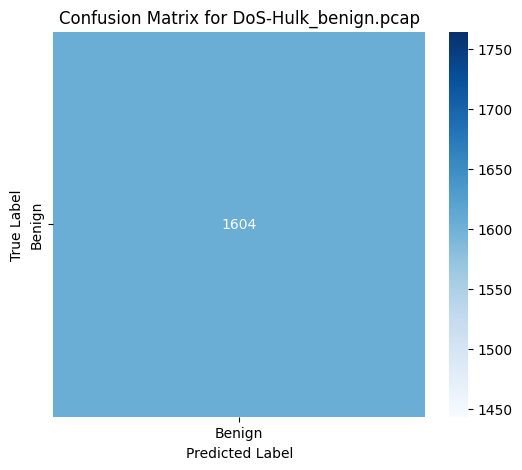


--- Confusion Matrix for Normal-h3_6.pcap ---
[[303018]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


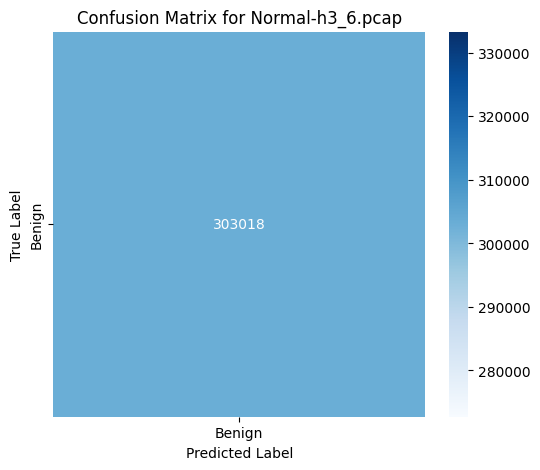


--- Confusion Matrix for Normal-h3_3.pcap ---
[[33652]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


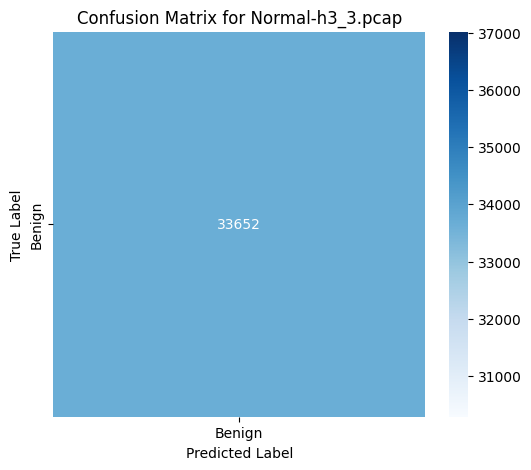


--- Confusion Matrix for Normal-h3_9.pcap ---
[[127459]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


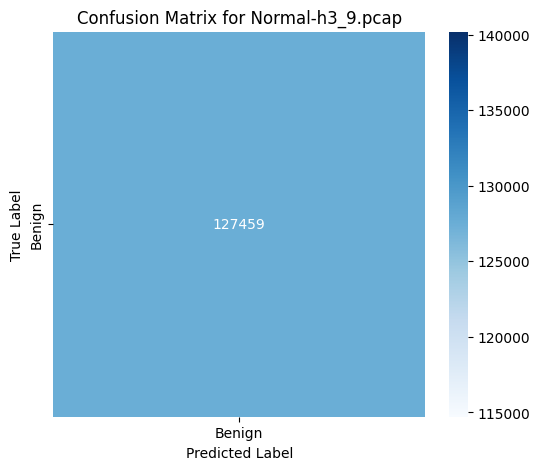


--- Confusion Matrix for Normal-h3_12.pcap ---
[[325015]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


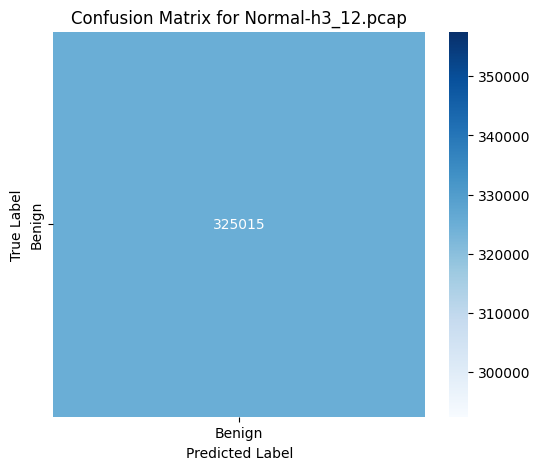


--- Confusion Matrix for Normal-h3_2.pcap ---
[[101932]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


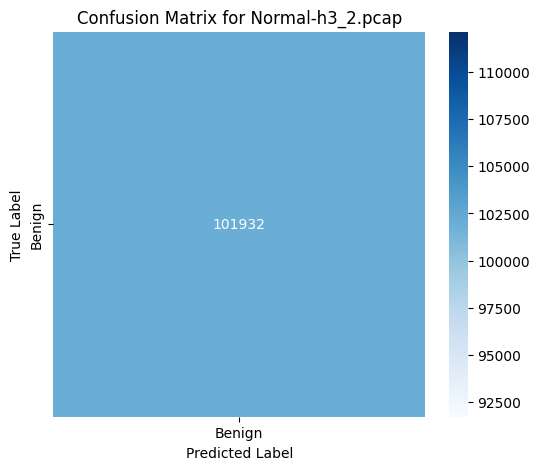


--- Confusion Matrix for Normal-h3_8.pcap ---
[[101525]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


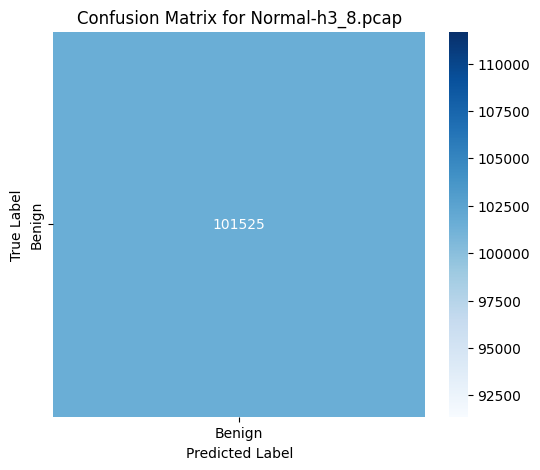


--- Confusion Matrix for Normal-h3_4.pcap ---
[[204455     26]
 [     0      0]]


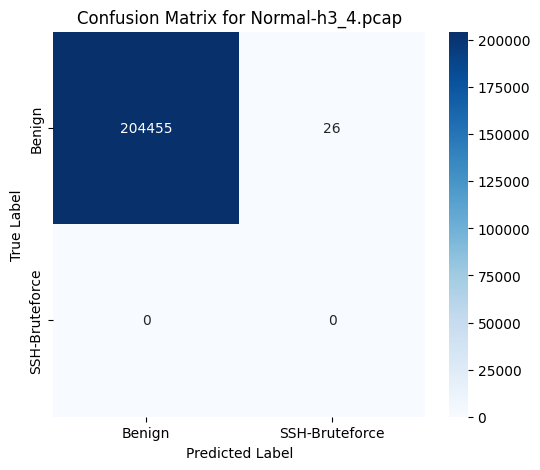

In [31]:
# prompt: print confsion matrix of each pcap file instead possible?
# # prompt: do confusion matrix of the from sklearn.metrics import classification_report
# # all_true_labels = []
# # all_predicted_labels = []
# # for attack in attacks:
# #     pcap_files = os.listdir(f'/content/{attack}')
# #     for pcap_file in pcap_files:
# #         file_name = pcap_file.split('.')[0]
# #         prediction_file_name = f'{file_name}_prediction.csv'
# #         prediction_file_dir = f'/content/{attack}_prediction/'
# #         prediction_csv_path = f'{prediction_file_dir}/{prediction_file_name}'
# #         try:
# #             df_prediction = pd.read_csv(prediction_csv_path)
# #             # The true label for all packets in this file is the 'attack' name
# #             if attack != 'DoS-SlowRate':
# #                 true_label = attack
# #             else:
# #                 true_label = 'DoS-Slow-Rate'
# #             # Collect the predicted label for each packet from 'Chosen_Label'
# #             predicted_labels = df_prediction['Chosen_Label'].tolist()
# #             # Extend our master lists
# #             all_true_labels.extend([true_label] * len(predicted_labels))
# #             all_predicted_labels.extend(predicted_labels)
# #         except FileNotFoundError:
# #             print(f"Prediction file not found for {pcap_file}: {prediction_csv_path}")
# #         except Exception as e:
# #             print(f"Error processing prediction file {prediction_csv_path}: {e}")
# # # Now, print the classification report using the collected true and predicted labels
# # if all_true_labels and all_predicted_labels:
# #     print("\n--- Classification Report ---")
# #     # Ensure both lists are of the same length
# #     if len(all_true_labels) == len(all_predicted_labels):
# #         print(classification_report(all_true_labels, all_predicted_labels, zero_division=0))
# #     else:
# #         print("Error: Mismatch in the number of true labels and predicted labels.")
# # else:
# #     print("\nNo data collected to generate a classification report.")

# Print confusion matrix for each pcap file
for attack in attacks:
    pcap_files = os.listdir(f'/content/{attack}')
    for pcap_file in pcap_files:
        file_name = pcap_file.split('.')[0]
        prediction_file_name = f'{file_name}_prediction.csv'
        prediction_file_dir = f'/content/{attack}_prediction/'
        prediction_csv_path = f'{prediction_file_dir}/{prediction_file_name}'

        try:
            df_prediction = pd.read_csv(prediction_csv_path)

            # Determine the true label for this file
            if attack != 'DoS-SlowRate':
                true_label = attack
            else:
                true_label = 'DoS-Slow-Rate'

            # Extract true and predicted labels for this specific file
            true_labels_file = [true_label] * len(df_prediction)
            predicted_labels_file = df_prediction['Chosen_Label'].tolist()

            print(f"\n--- Confusion Matrix for {pcap_file} ---")

            if true_labels_file and predicted_labels_file and len(true_labels_file) == len(predicted_labels_file):
                # Get all unique labels present in both true and predicted lists for this file
                unique_labels_file = sorted(list(set(true_labels_file + predicted_labels_file)))

                # Generate confusion matrix for this file
                cm_file = confusion_matrix(true_labels_file, predicted_labels_file, labels=unique_labels_file)
                print(cm_file)

                # Optional: Visualize the confusion matrix for this file
                plt.figure(figsize=(6, 5))
                sns.heatmap(cm_file, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels_file, yticklabels=unique_labels_file)
                plt.xlabel('Predicted Label')
                plt.ylabel('True Label')
                plt.title(f'Confusion Matrix for {pcap_file}')
                plt.show()
            else:
                print(f"No valid data to generate confusion matrix for {pcap_file}.")

        except FileNotFoundError:
            print(f"\nPrediction file not found for {pcap_file}: {prediction_csv_path}")
        except Exception as e:
            print(f"\nError processing prediction file {prediction_csv_path}: {e}")



In [32]:
# prompt: print every result as dataframe display

from IPython.display import display

for attack in attacks:
    result_csv_path = f'/content/Result/{attack}_result.csv'
    if os.path.exists(result_csv_path):
        df_result = pd.read_csv(result_csv_path)
        print(f"\n--- Results for {attack} ---")
        print(df_result)
    else:
        print(f"\nNo result file found for {attack}.")
    print("-" * 40)


--- Results for Benign ---
                    File_Name          Result  Attack
0           Normal-h3_11.pcap          Benign  Benign
1            Normal-h3_1.pcap          Benign  Benign
2            Normal-h3_5.pcap   DoS-Slow-Rate  Benign
3           Normal-h3_10.pcap          Benign  Benign
4   DoS-GoldenEye_benign.pcap          Benign  Benign
5        DoS-Hulk_benign.pcap          Benign  Benign
6            Normal-h3_6.pcap          Benign  Benign
7            Normal-h3_3.pcap          Benign  Benign
8            Normal-h3_9.pcap          Benign  Benign
9           Normal-h3_12.pcap          Benign  Benign
10           Normal-h3_2.pcap          Benign  Benign
11           Normal-h3_8.pcap          Benign  Benign
12           Normal-h3_4.pcap  SSH-Bruteforce  Benign
----------------------------------------
